# Part 1 - Initial IMDB Data Processing
- James M. Irving

## Business Problem

<img src="Images/movies-generic-header.png" width=300px>

> I have been hired to produce analyze IMDB's extensive publicly-available dataset, supplement it with financial data from TMDB's API, convert the raw data into a MySQL database, and then use that database for extracting insights and recommendations on how to make a successful movie.

I will use a combination of machine-learning-model-based insights and hypothesis testing to extract insights for our stakeholder.
    

  
### Specifications/Constraints    
- The stakeholder wants to focus on attributes of the movies themselves, vs the actors and directors connected to those movies. 
- They only want to include information related to movies released in the United States.
- They also did not want to include movies released before the year 2000.
- The stakeholder is particularly interested in how the MPAA rating, genre(s), runtime, budget, and production companies influence movie revenue and user-ratings.

# Initial IMDB Data Processing

### IMDB Movie Metadata
- I will download fresh movie metadata from IMDB's public datasets and filter out movies that meet the stakeholder's requirements/constraints.

- IMDB Provides Several Files with varied information for Movies, TV Shows, Made for TV Movies, etc.
    - Overview/Data Dictionary: <a href="https://www.imdb.com/interfaces/" target="_blank">https://www.imdb.com/interfaces/</a>

    - Downloads page: <a href="https://datasets.imdbws.com/" target="_blank">https://datasets.imdbws.com/</a>
- Files to use:
    - title.basics.tsv.gz
    - title.ratings.tsv.gz
    - title.akas.tsv.gz
  

## Imports and Downloading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno

In [2]:
## Importing custom function for project
%load_ext autoreload
%autoreload 2
import project_functions as pf

In [3]:
## Making "Data" Folder to save IMDB files
os.makedirs("Data/",exist_ok=True)
sorted(os.listdir("Data/"))

['combined_tmdb_api_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2011.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json']

## Processing Title Basics

In [4]:
## title basics 
url_title_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
basics = pd.read_csv(url_title_basics, sep='\t',low_memory=False)
basics.info()
basics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8936772 entries, 0 to 8936771
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 613.6+ MB


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


### Specified Filtering/Cleaning Steps:
- Permanent Steps
    - Replace "\N" with np.nan
    - keep only titleType==Movie
    - keep startYear 2000-2022
    
- Steps to Revisit/Reconsider:
    - Eliminate movies that include  "Documentary" in genre (see tip below)
    - Eliminate movies that are null for runtimeMinutes
    - Eliminate movies that are null for genre


In [5]:
# pf.check_nulls_nunique()
# def check_nulls_nunique(df,plot=True):
#     report = pd.DataFrame({"# null":df.isna().sum(),
#                  "% null":df.isna().sum()/len(df)*100,
#                  '# unique':df.nunique(),
#                           '% unique':df.nunique()/len(df)*100})
#     display(report.round(2))
#     if plot:
#         missingno.matrix(df)
#         plt.show()
    

#### Check for Nulls Values & \N placeholders

,# null,% null,# unique,% unique
tconst,0,0.0,8936772,100.00
titleType,0,0.0,11,0.00
primaryTitle,11,0.0,4123167,46.14
originalTitle,11,0.0,4143118,46.36
isAdult,0,0.0,9,0.00
startYear,0,0.0,151,0.00
endYear,0,0.0,98,0.00
runtimeMinutes,0,0.0,870,0.01
genres,10,0.0,2314,0.03


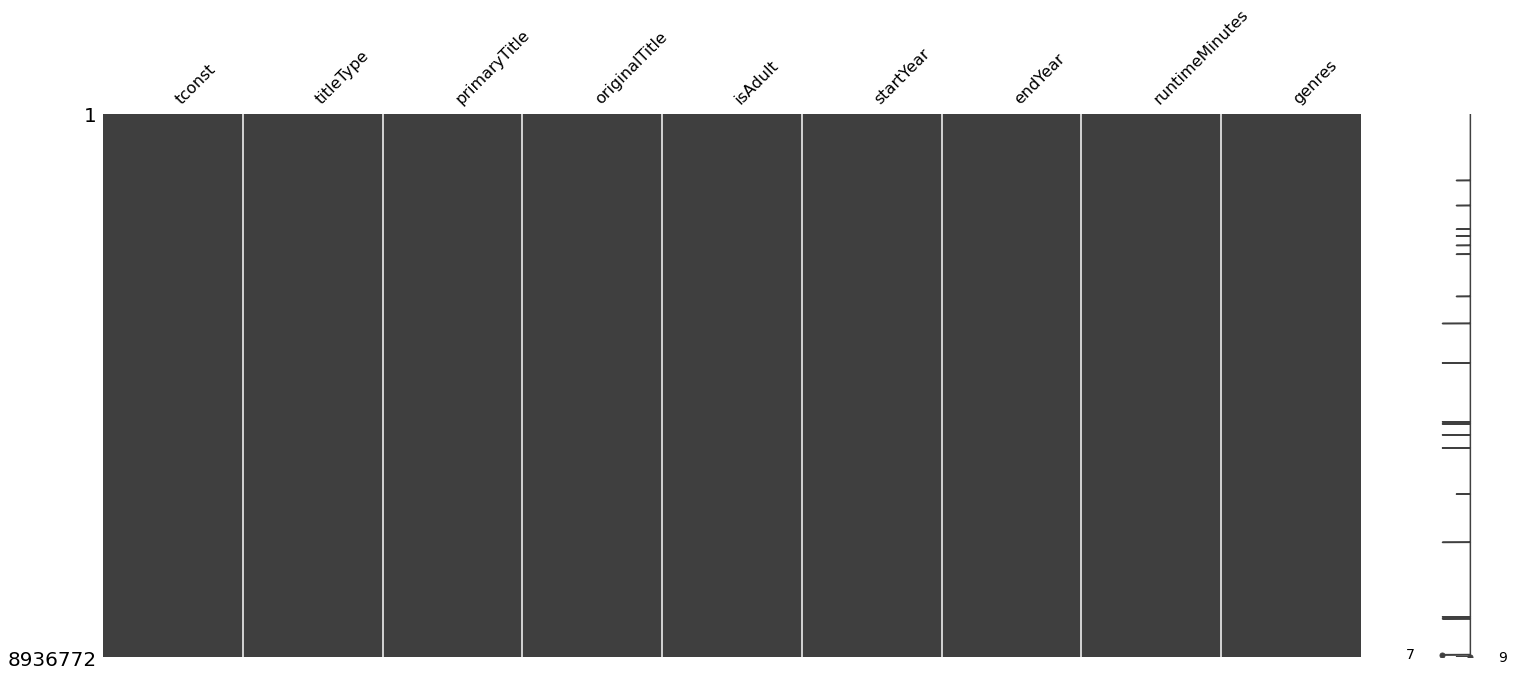

In [6]:
## checking null values
pf.check_nulls_nunique(basics)

,# null,% null,# unique,% unique
tconst,0,0.00,8936772,100.00
titleType,0,0.00,11,0.00
primaryTitle,11,0.00,4123167,46.14
originalTitle,11,0.00,4143118,46.36
isAdult,1,0.00,8,0.00
startYear,1191796,13.34,150,0.00
endYear,8845949,98.98,97,0.00
runtimeMinutes,6532119,73.09,869,0.01
genres,408374,4.57,2313,0.03


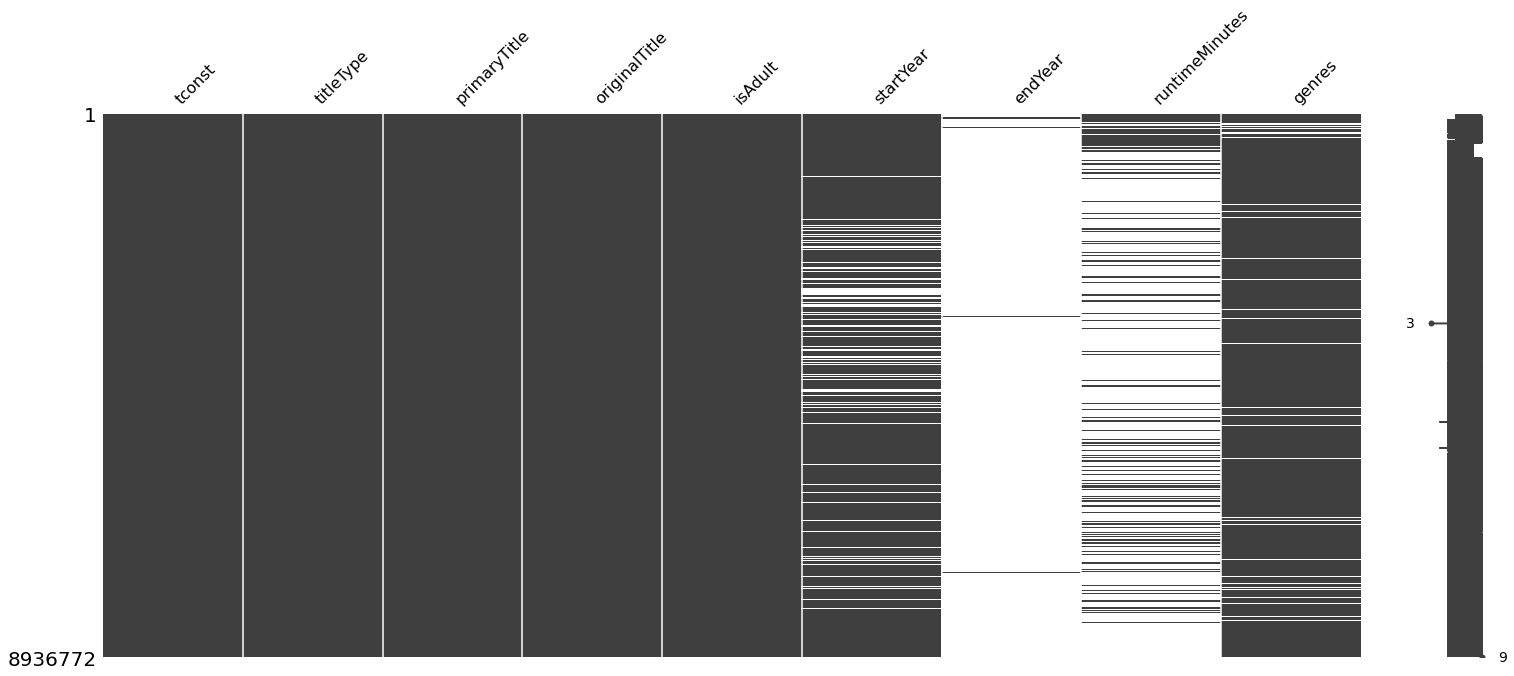

In [7]:
## Replace "\N" with np.nan
basics.replace({'\\N':np.nan},inplace=True)
pf.check_nulls_nunique(basics)

##### Observations:
- Note: `endYear` is a pretty worthless column, in relation to movies. For TV shows, this would have potentially been worth keeping. 
    - Decision: Drop column.
- `tconst` vs `primary_title`:
    - I find it somehow odd that there are unique tconst values for every row, but that only ~ 46% of the titles are unique values.
        - Decision: change nothing, for now, but remember this for later.
        
- `genres` are missing for <5% of the movies.
    - Decision: we care about genre, so we will drop null values from genre.

- `startYear` is missing for 13% of the data. This may reflect movies that yet to be released.
    - Decision: drop null values for now. Alternative future approach would be to confirm movie status by joining with other table containing release information.
    
- `runtimeMinutes` is missing from a whopping 73% of the data. 
    - Decision: since this is a feature we care about, it is vital to our analysis. We will drop null values from this feature to reduce the overall number of API calls needed in Part 2.

In [8]:
## Eliminate movies that are null for runtimeMinute, genres, and startYear
basics = basics.dropna(subset=['runtimeMinutes','genres','startYear'])
pf.check_nulls_nunique(basics, plot=False)

,# null,% null,# unique,% unique
tconst,0,0.00,2303611,100.00
titleType,0,0.00,10,0.00
primaryTitle,0,0.00,1648182,71.55
originalTitle,0,0.00,1665312,72.29
isAdult,0,0.00,2,0.00
startYear,0,0.00,147,0.01
endYear,2260427,98.13,95,0.00
runtimeMinutes,0,0.00,848,0.04
genres,0,0.00,2187,0.09


In [9]:
## drop endYear
basics = basics.drop(columns=['endYear'])
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...
8936722,tt9916754,movie,Chico Albuquerque - Revelações,Chico Albuquerque - Revelações,0,2013,49,Documentary
8936728,tt9916766,tvEpisode,Episode #10.15,Episode #10.15,0,2019,43,"Family,Game-Show,Reality-TV"
8936763,tt9916840,tvEpisode,Horrid Henry's Comic Caper,Horrid Henry's Comic Caper,0,2014,11,"Adventure,Animation,Comedy"
8936770,tt9916856,short,The Wind,The Wind,0,2015,27,Short


### Filtering for Stakeholder Specifications

#### Keeping only Full-Length Movies Released in Theaters

In [10]:
## Checking title types
basics['titleType'].value_counts()

tvEpisode       1004883
short            558992
movie            355057
video            172099
tvMovie           87185
tvSeries          84445
tvSpecial         15975
tvMiniSeries      15487
tvShort            9198
videoGame           290
Name: titleType, dtype: int64

In [11]:
## keep only titleType==Movie
basics = basics.loc[ basics['titleType']=='movie']
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,90,Drama
672,tt0000679,movie,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,0,1908,120,"Adventure,Fantasy"
1172,tt0001184,movie,Don Juan de Serrallonga,Don Juan de Serrallonga,0,1910,58,"Adventure,Drama"
1273,tt0001285,movie,The Life of Moses,The Life of Moses,0,1909,50,"Biography,Drama,Family"
...,...,...,...,...,...,...,...,...
8936537,tt9916362,movie,Coven,Akelarre,0,2020,92,"Drama,History"
8936621,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019,123,Drama
8936662,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,57,Documentary
8936689,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,100,Documentary


#### Eliminating Documentaries

In [12]:

is_documentary = basics['genres'].str.contains('documentary',case=False)
is_documentary.value_counts()

False    270428
True      84629
Name: genres, dtype: int64

In [13]:
# ## Eliminate movies that include  "Documentary" in genre 
# is_documentary = basics['genres'].str.contains('documentary',case=False)
# basics = basics[~is_documentary]
# basics.head()

In [14]:
### Convert startyear to numeric for slicing
## convert numeric features
basics['startYear'] = basics['startYear'].astype(float)

/var/folders/rf/vw4r41jd7vd95x1w0dth7v9h0000gp/T/ipykernel_7827/3247079554.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basics['startYear'] = basics['startYear'].astype(float)


In [15]:
## keep startYear 2000-2022
basics = basics[(basics['startYear']>=2000)&(basics['startYear']<2023)]
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
13082,tt0013274,movie,Istoriya grazhdanskoy voyny,Istoriya grazhdanskoy voyny,0,2021.0,133,Documentary
34805,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,118,"Comedy,Fantasy,Romance"
61119,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,70,Drama
67672,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,122,Drama
77968,tt0079644,movie,November 1828,November 1828,0,2001.0,140,"Drama,War"
...,...,...,...,...,...,...,...,...
8936537,tt9916362,movie,Coven,Akelarre,0,2020.0,92,"Drama,History"
8936621,tt9916538,movie,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,0,2019.0,123,Drama
8936662,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015.0,57,Documentary
8936689,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007.0,100,Documentary


## Processing Title Ratings

#### Specified Filtering Steps:
- Ratings
    - Replace "\N" with np.nan (if any)
    
- Keep movies that are in final filtered basics dataframe


In [16]:
## title ratings
url_title_ratings ="https://datasets.imdbws.com/title.ratings.tsv.gz"
ratings = pd.read_csv(url_title_ratings,sep='\t',low_memory=False)
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245857 entries, 0 to 1245856
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1245857 non-null  object 
 1   averageRating  1245857 non-null  float64
 2   numVotes       1245857 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.5+ MB


,tconst,averageRating,numVotes
0,tt0000001,5.7,1879
1,tt0000002,5.9,249
2,tt0000003,6.5,1657
3,tt0000004,5.8,162
4,tt0000005,6.2,2483


,# null,% null,# unique,% unique
tconst,0,0.0,1245857,100.00
averageRating,0,0.0,91,0.01
numVotes,0,0.0,20241,1.62


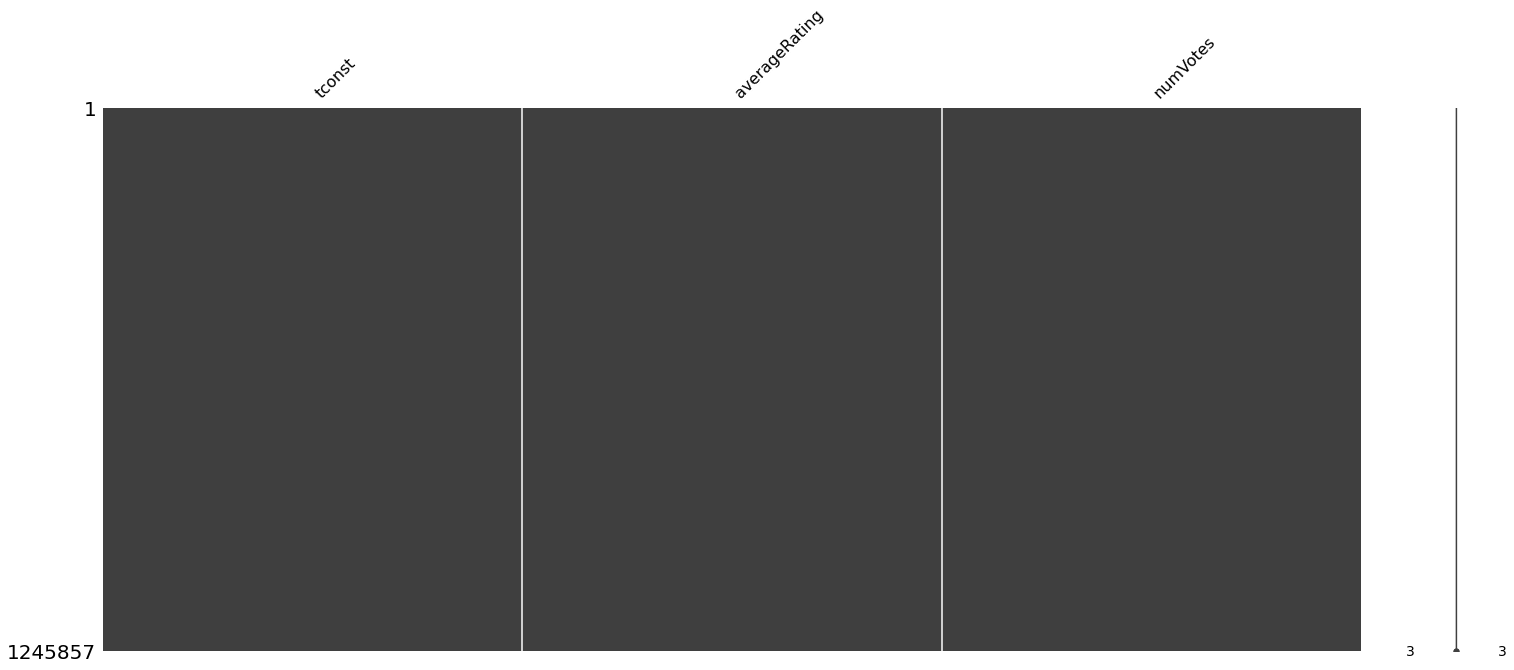

In [17]:
# Replace "\N" with np.nan (if any)
ratings.replace({'\\N':np.nan},inplace=True)
pf.check_nulls_nunique(ratings)

## Processing Title AKAs

#### Specified Filtering Steps:
- keep only US entries.
- Replace "\N" with np.nan

In [18]:
## title AKAs
url_title_akas ="https://datasets.imdbws.com/title.akas.tsv.gz"
akas = pd.read_csv(url_title_akas,sep='\t',low_memory=False)
akas.info()
akas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32037067 entries, 0 to 32037066
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   titleId          object
 1   ordering         int64 
 2   title            object
 3   region           object
 4   language         object
 5   types            object
 6   attributes       object
 7   isOriginalTitle  object
dtypes: int64(1), object(7)
memory usage: 1.9+ GB


,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [19]:
## The AKAs file has the information on country where it released and language
akas = akas[(akas['region'] == 'US')]
akas

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
5,tt0000001,6,Carmencita,US,\N,imdbDisplay,\N,0
14,tt0000002,7,The Clown and His Dogs,US,\N,\N,literal English title,0
33,tt0000005,10,Blacksmith Scene,US,\N,imdbDisplay,\N,0
36,tt0000005,1,Blacksmithing Scene,US,\N,alternative,\N,0
41,tt0000005,6,Blacksmith Scene #1,US,\N,alternative,\N,0
...,...,...,...,...,...,...,...,...
32036738,tt9916702,1,Loving London: The Playground,US,\N,imdbDisplay,\N,0
32036776,tt9916720,10,The Demonic Nun,US,\N,tv,\N,0
32036778,tt9916720,12,The Nun 2,US,\N,imdbDisplay,\N,0
32036795,tt9916756,1,Pretty Pretty Black Girl,US,\N,imdbDisplay,\N,0


In [20]:
# ## check for null values
# akas.isna().sum()

,# null,% null,# unique,% unique
titleId,0,0.00,1244676,94.11
ordering,0,0.00,109,0.01
title,0,0.00,1021727,77.25
region,0,0.00,1,0.00
language,1319057,99.73,8,0.00
types,296988,22.45,13,0.00
attributes,1278586,96.67,163,0.01
isOriginalTitle,1375,0.10,2,0.00


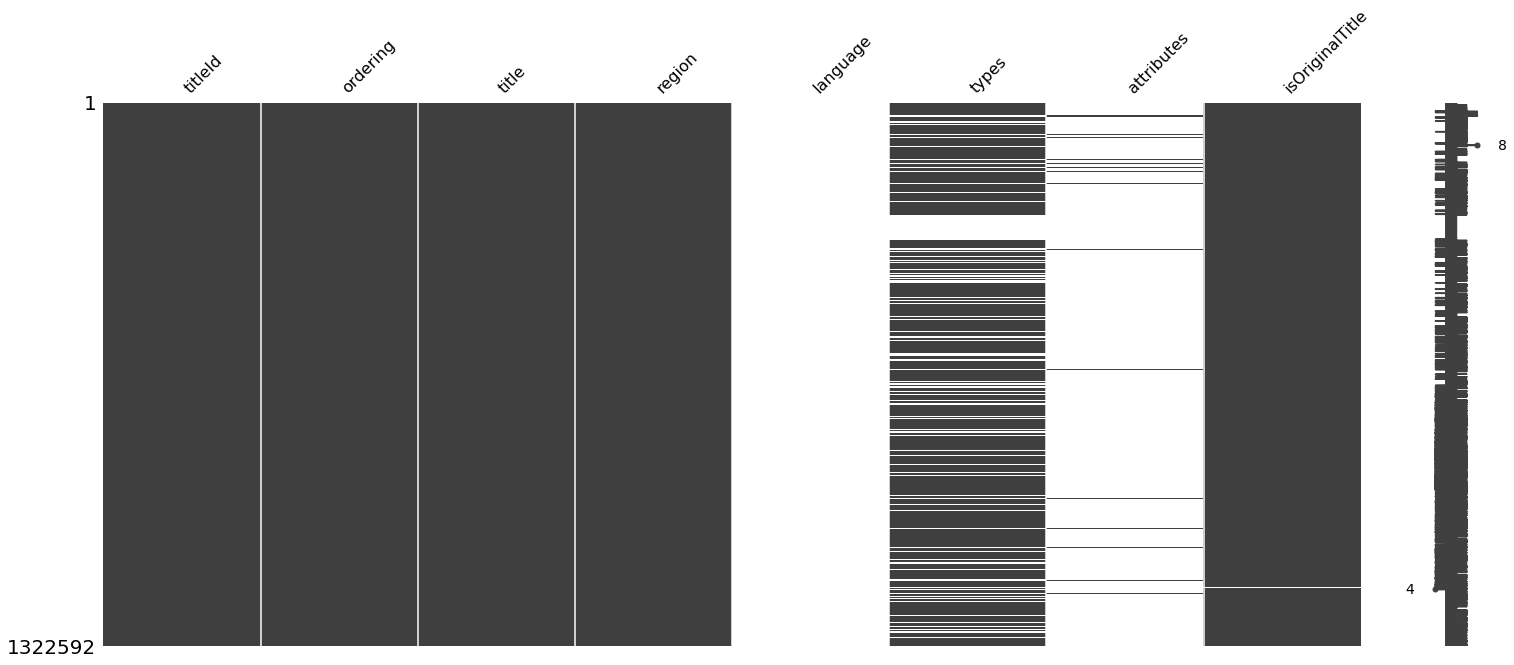

In [21]:
## replace\N placeholders with NaN and re-check for nuls
akas.replace({'\\N':np.nan},inplace=True)
pf.check_nulls_nunique(akas)

#### Observations:
- `language`: workthless, drop it.
- `types`: explore

In [22]:
akas.drop(columns='language',inplace=True)
akas.head()

,titleId,ordering,title,region,types,attributes,isOriginalTitle
5,tt0000001,6,Carmencita,US,imdbDisplay,NaN,0
14,tt0000002,7,The Clown and His Dogs,US,NaN,literal English title,0
33,tt0000005,10,Blacksmith Scene,US,imdbDisplay,NaN,0
36,tt0000005,1,Blacksmithing Scene,US,alternative,NaN,0
41,tt0000005,6,Blacksmith Scene #1,US,alternative,NaN,0


#### Exploring Types

<AxesSubplot:>

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env-m1/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


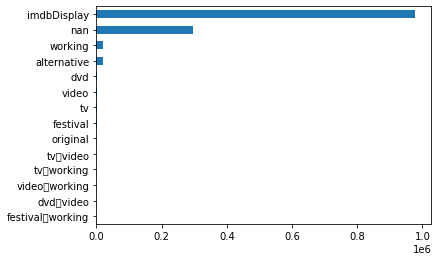

In [23]:
akas['types'].value_counts(dropna=False).sort_values().plot(kind='barh')

> Keep all types, since this table will mainly be used for filtering region and perhaps referenced later for comparing duplicate titles that had unique ids in title basics.

## Final Filtering: Removing Non-US Movies

- Now that both AKAs and basics have been processed, we can remove any movie ids from title basics that are NOT in the US-filtered AKAs dataframe.

### Removing Non-US From Title Basics

In [24]:
## Only keep movie ids that are in the final filtered akas
keepers = basics['tconst'].isin(akas['titleId'])
basics = basics[keepers]
basics

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
34805,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,118,"Comedy,Fantasy,Romance"
61119,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,70,Drama
67672,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,122,Drama
86806,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,100,"Comedy,Horror,Sci-Fi"
91077,tt0093119,movie,Grizzly II: Revenge,Grizzly II: The Predator,0,2020.0,74,"Horror,Music,Thriller"
...,...,...,...,...,...,...,...,...
8936125,tt9915436,movie,Vida em Movimento,Vida em Movimento,0,2019.0,70,Documentary
8936304,tt9915872,movie,The Last White Witch,My Girlfriend is a Wizard,0,2019.0,97,"Comedy,Drama,Fantasy"
8936444,tt9916170,movie,The Rehearsal,O Ensaio,0,2019.0,51,Drama
8936453,tt9916190,movie,Safeguard,Safeguard,0,2020.0,90,"Action,Adventure,Thriller"


### Removing Non-US From Ratings

- I originally used the AKAs table to filter out which movies to keep from ratings.
- I decided to compare using the AKAs table VS the using the basics table, which has already had non-US movies removed.
- Since I will 

In [25]:
## Keeping only movie that exist in basics 
keepers_akas = ratings['tconst'].isin(akas['titleId'])
keepers_basics = ratings['tconst'].isin(basics['tconst'])

print('- If filter using AKAs:')
display(keepers_akas.value_counts())

print('- If filter using Basics:')
display(keepers_basics.value_counts())

- If filter using AKAs:


False    775271
True     470586
Name: tconst, dtype: int64

- If filter using Basics:


False    1160847
True       85010
Name: tconst, dtype: int64

> **MUST DECIDE HOW TO DETERMINE FINAL KEEERS AND IF REMOVING DOCUMENTARIES OR NOT**

In [26]:
ratings_final = ratings[keepers_basics]
ratings_final

,tconst,averageRating,numVotes
17913,tt0035423,6.4,83782
40758,tt0062336,6.4,161
46611,tt0069049,6.7,7231
63600,tt0088751,5.2,320
67382,tt0093119,2.9,1181
...,...,...,...
1245789,tt9915436,7.4,5
1245810,tt9915872,6.9,8
1245823,tt9916170,6.7,6
1245824,tt9916190,3.6,233


## Saving Final Files

#### Saving Title Basics

In [27]:
## Saving and immediately loading (to verify)
basics.to_csv('Data/title_basics_cleaned.csv.gz',compression='gzip',index=False)
basics = pd.read_csv('Data/title_basics_cleaned.csv.gz')
basics.info()
basics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112886 entries, 0 to 112885
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   tconst          112886 non-null  object 
 1   titleType       112886 non-null  object 
 2   primaryTitle    112886 non-null  object 
 3   originalTitle   112886 non-null  object 
 4   isAdult         112886 non-null  int64  
 5   startYear       112886 non-null  float64
 6   runtimeMinutes  112886 non-null  int64  
 7   genres          112886 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 6.9+ MB


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,70,Drama
2,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,122,Drama
3,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,100,"Comedy,Horror,Sci-Fi"
4,tt0093119,movie,Grizzly II: Revenge,Grizzly II: The Predator,0,2020.0,74,"Horror,Music,Thriller"


#### Saving Title Ratings

In [28]:
ratings_final.to_csv('Data/title_ratings_cleaned.csv.gz',compression='gzip',index=False)
ratings = pd.read_csv('Data/title_ratings_cleaned.csv.gz')
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85010 entries, 0 to 85009
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         85010 non-null  object 
 1   averageRating  85010 non-null  float64
 2   numVotes       85010 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ MB


,tconst,averageRating,numVotes
0,tt0035423,6.4,83782
1,tt0062336,6.4,161
2,tt0069049,6.7,7231
3,tt0088751,5.2,320
4,tt0093119,2.9,1181


#### Saving Title AKAs

In [29]:
akas.to_csv('Data/title_akas_cleaned.csv.gz',compression='gzip',index=False)
akas = pd.read_csv('Data/title_akas_cleaned.csv.gz')
akas.info()
akas.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322592 entries, 0 to 1322591
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   titleId          1322592 non-null  object 
 1   ordering         1322592 non-null  int64  
 2   title            1322592 non-null  object 
 3   region           1322592 non-null  object 
 4   types            1025604 non-null  object 
 5   attributes       44006 non-null    object 
 6   isOriginalTitle  1321217 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 70.6+ MB


,titleId,ordering,title,region,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,alternative,NaN,0.0


### Optional Check for files in Data folder

In [30]:
# optional 
sorted(os.listdir("Data/"))

['combined_tmdb_api_data.csv.gz',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2002.csv.gz',
 'final_tmdb_data_2003.csv.gz',
 'final_tmdb_data_2004.csv.gz',
 'final_tmdb_data_2005.csv.gz',
 'final_tmdb_data_2006.csv.gz',
 'final_tmdb_data_2007.csv.gz',
 'final_tmdb_data_2008.csv.gz',
 'final_tmdb_data_2009.csv.gz',
 'final_tmdb_data_2010.csv.gz',
 'final_tmdb_data_2011.csv.gz',
 'final_tmdb_data_2012.csv.gz',
 'final_tmdb_data_2013.csv.gz',
 'title_akas_cleaned.csv.gz',
 'title_basics_cleaned.csv.gz',
 'title_ratings_cleaned.csv.gz',
 'tmdb_api_results_2000.json']

## Final Movie Count

In [31]:
print(f"There are {len(basics):,} rows in title_basics")
print(f"There are {len(ratings):,} rows in title_ratings")
print(f"There are {len(akas):,} rows in akas")

There are 112,886 rows in title_basics
There are 85,010 rows in title_ratings
There are 1,322,592 rows in akas


> See notebook "`Part 2A - TMDB API Calls.ipynb`" for the next part of the analysis.